<a href="https://colab.research.google.com/github/EthanCui2008/Kaggle/blob/Main/House_Prices_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
!wget "https://raw.githubusercontent.com/EthanCui2008/Kaggle/Main/house-prices-advanced-regression-techniques%20(1)/train.csv"
!wget "https://raw.githubusercontent.com/EthanCui2008/Kaggle/Main/house-prices-advanced-regression-techniques%20(1)/test.csv"
!wget "https://raw.githubusercontent.com/EthanCui2008/Kaggle/Main/house-prices-advanced-regression-techniques%20(1)/sample_submission.csv"

--2024-07-12 18:36:05--  https://raw.githubusercontent.com/EthanCui2008/Kaggle/Main/house-prices-advanced-regression-techniques%20(1)/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 449.88K  --.-KB/s    in 0.06s   

2024-07-12 18:36:06 (6.97 MB/s) - ‘train.csv’ saved [460676/460676]

--2024-07-12 18:36:06--  https://raw.githubusercontent.com/EthanCui2008/Kaggle/Main/house-prices-advanced-regression-techniques%20(1)/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP re

In [8]:
train_ds = pd.read_csv('train.csv')

train_len = len(train_ds)

#Drops Both ID and Neighborhood, along with getting rid of none types
def format_data(in_ds):

  out_ds = in_ds.drop(columns=['Id',"Neighborhood"])

  for column in out_ds.columns:
    if out_ds[column].dtype == 'float64':
        out_ds[column].fillna(0, inplace=True)
    elif out_ds[column].dtype == 'object':
        out_ds[column].fillna('NaN', inplace=True)
  return out_ds

#For every string column, collects all the unique string types, outputs a dictionary
def get_unique_strings_with_columns(dataframe):
    unique_strings = {}
    for column in dataframe.select_dtypes(include='object'):
        unique_values = dataframe[column].dropna().unique()
        unique_strings[column] = unique_values
        unique_strings[column].sort()
    return unique_strings

train_ds = format_data(train_ds)
unique_strings = get_unique_strings_with_columns(train_ds)
print(unique_strings)

{'MSZoning': array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object), 'Street': array(['Grvl', 'Pave'], dtype=object), 'Alley': array(['Grvl', 'NaN', 'Pave'], dtype=object), 'LotShape': array(['IR1', 'IR2', 'IR3', 'Reg'], dtype=object), 'LandContour': array(['Bnk', 'HLS', 'Low', 'Lvl'], dtype=object), 'Utilities': array(['AllPub', 'NoSeWa'], dtype=object), 'LotConfig': array(['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'], dtype=object), 'LandSlope': array(['Gtl', 'Mod', 'Sev'], dtype=object), 'Condition1': array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe',
       'RRNn'], dtype=object), 'Condition2': array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNn'],
      dtype=object), 'BldgType': array(['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'], dtype=object), 'HouseStyle': array(['1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story',
       'SFoyer', 'SLvl'], dtype=object), 'RoofStyle': array(['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Sh

In [9]:
#I wrote this so i'd feel less bad about using string concatenation unironically, given a column, and a string type in that column, creates a new string
def str_cl_cat(column, type_string):
  return column + "_" + type_string

#Given a Dataset with columns of strings, creates new columns for each unique string, in that column, 1 means that string appeared in the original column
#This was a work around to find a way to collect more data

def string_column_convert(in_ds):
  #For Efficiency
  new_columns = {}

  for column_name in in_ds.select_dtypes(include='object'):
    column = in_ds[column_name]
    #Create New Columns
    for ustring in unique_strings[column_name]:
      if (ustring != 'NaN'):
        new_columns[str_cl_cat(column_name, ustring)] = [0] * in_ds.shape[0]

    for i_string in range(len(column)):
      if (column[i_string] != 'NaN'):
        new_columns[str_cl_cat(column_name,column[i_string])][i_string] = 1

  #Get Rid of Old Columns
  in_ds = in_ds.select_dtypes(exclude=['object'])

  new_columns_df = pd.DataFrame(new_columns)
  in_ds = pd.concat([in_ds, new_columns_df], axis=1)

  return in_ds

train_ds_post = string_column_convert(train_ds)



In [10]:
train_ds_post.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,

In [19]:
Y_ds_train = train_ds_post['SalePrice']

scaler = RobustScaler()
robust_scaled_data = scaler.fit_transform(train_ds_post.drop(columns=['SalePrice']))

X_ds_train = pd.DataFrame(robust_scaled_data, columns=train_ds_post.drop(columns=['SalePrice']).columns)

X_train, X_test, y_train, y_test = train_test_split(X_ds_train, Y_ds_train, test_size=0.01, random_state=42)

input_dim = X_train.shape[1]

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1445 entries, 1113 to 1126
Columns: 262 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(262)
memory usage: 2.9 MB


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, ELU, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

model = Sequential()

model = Sequential()
model.add(Dense(units=300, activation='relu', input_shape=(X_train.shape[1],)))  # Input layer
model.add(Dropout(0.1))  # Dropout for regularization
model.add(Dense(units=150, activation='relu'))  # Hidden layer 1
model.add(Dropout(0.1))  # Dropout for regularization
model.add(Dense(units=70, activation='relu'))  # Hidden layer 2
model.add(Dense(1, activation='linear'))


initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 300)               78900     
                                                                 
 dropout_3 (Dropout)         (None, 300)               0         
                                                                 
 dense_6 (Dense)             (None, 150)               45150     
                                                                 
 dropout_4 (Dropout)         (None, 150)               0         
                                                                 
 dense_7 (Dense)             (None, 70)                10570     
                                                                 
 dense_8 (Dense)             (None, 1)                 71        
                                                                 
Total params: 134691 (526.14 KB)
Trainable params: 134

In [22]:
# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
37/37 [==============================] - 3s 68ms/step - loss: 39293026304.0000 - accuracy: 0.0000e+00 - val_loss: 37414633472.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
37/37 [==============================] - 0s 6ms/step - loss: 37949136896.0000 - accuracy: 0.0000e+00 - val_loss: 33781174272.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
37/37 [==============================] - 0s 7ms/step - loss: 34129963008.0000 - accuracy: 0.0000e+00 - val_loss: 28403587072.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
37/37 [==============================] - 0s 6ms/step - loss: 30065563648.0000 - accuracy: 0.0000e+00 - val_loss: 25133711360.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
37/37 [==============================] - 0s 9ms/step - loss: 26269622272.0000 - accuracy: 0.0000e+00 - val_loss: 22276775936.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
37/37 [==============================] - 0s 10ms/step - loss: 22243289088.000

1/1 [==============================] - 0s 27ms/step - loss: 858898688.0000 - accuracy: 0.0000e+00
Test loss: [858898688.0, 0.0]


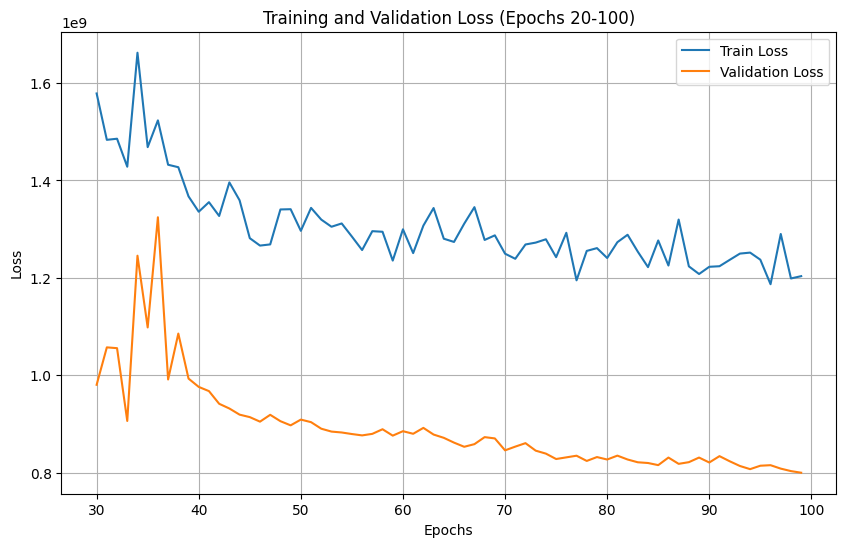

In [23]:
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

start_epoch = 30
end_epoch = 100

# Slice the history to include only the specified range of epochs
train_loss = history.history['loss'][start_epoch:end_epoch]
val_loss = history.history['val_loss'][start_epoch:end_epoch]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(start_epoch, end_epoch), train_loss, label='Train Loss')
plt.plot(range(start_epoch, end_epoch), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Epochs 20-100)')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
X_test_return = model.predict(X_test)
y_test_return = y_test.tolist()
test_len = len(X_test_return)
print(test_len)
avg_acc = 0
for i in range(test_len):
  avg_acc+=(abs(X_test_return[i]-y_test_return[i])/y_test_return[i])
print(avg_acc/test_len)

1/1 [==============================] - 0s 69ms/step
15
[0.15591217]


In [25]:
test_file_path = pd.read_csv('test.csv')

test_file_path = format_data(test_file_path)
test_file_path = string_column_convert(test_file_path)
test_file_path = scaler.fit_transform(test_file_path)

sample_submission_df = pd.read_csv('sample_submission.csv')
sample_submission_df.info()

sample_submission_df['SalePrice'] = model.predict(test_file_path)
sample_submission_df.to_csv('submission.csv', index=False)
sample_submission_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB
46/46 [==============================] - 1s 6ms/step


,Id,SalePrice
0,1461,102068.710938
1,1462,188301.765625
2,1463,160654.562500
3,1464,182590.406250
4,1465,151966.656250
